In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [64]:
from os.path import join
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import pearsonr

rng_seed = 399
np.random.seed(rng_seed)
import persim
import joblib

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import tensorflow as tf
from tensorflow.keras.activations import relu
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1

# Directory constants
root_code_dir = ".."
output_dir = join(root_code_dir, "output")
word2vec_training_dir = join(output_dir, "word2vec_training")
word2vec_ann_indices_dir = join(output_dir, "word2vec_ann_indices")
word2vec_cluster_analysis_dir = join(output_dir, "word2vec_cluster_analysis")

# Extend sys path for importing custom Python files
import sys

sys.path.append(root_code_dir)

from topological_data_analysis.topological_polysemy import tps
from word_embeddings.word2vec import load_model_training_output

<IPython.core.display.Javascript object>

## Prepare data

In [81]:
# Load word meaning features and labels
word_meaning_features = np.load("data/word_meaning_features.npy")[:, 300:]
words_to_num_synsets = joblib.load("data/words_to_num_synsets.joblib")
word_meaning_labels = np.array(list(words_to_num_synsets.values()))
data_n, data_d = word_meaning_features.shape

<IPython.core.display.Javascript object>

In [13]:
# Load output from training word2vec
w2v_training_output = load_model_training_output(
    model_training_output_dir=join(
        word2vec_training_dir, "word2vec_enwiki_jan_2021_word2phrase"
    ),
    model_name="word2vec",
    dataset_name="enwiki",
    return_normalized_embeddings=True,
)
last_embedding_weights_normalized = w2v_training_output[
    "last_embedding_weights_normalized"
]
words = w2v_training_output["words"]
word_to_int = w2v_training_output["word_to_int"]
word_counts = w2v_training_output["word_counts"]

<IPython.core.display.Javascript object>

## Do modeling

In [83]:
def create_model(
    input_dim: int,
    lasso_alpha: float,
    optimizer: tf.keras.optimizers.Optimizer,
    loss: str,
) -> Model:
    """
    TODO: Docs
    """
    # Input layer
    input_layer = Input(shape=(input_dim,), name="input")

    # Output layer
    output_layer = Dense(1, kernel_regularizer=l1(lasso_alpha), name="output")(
        input_layer
    )

    # Create model and compile
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer, loss=loss)

    return model

<IPython.core.display.Javascript object>

In [115]:
wm_model = create_model(
    input_dim=data_d,
    lasso_alpha=0.5,
    optimizer=SGD(learning_rate=0.0001),
    loss=MSE,
)
wm_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 22)]              0         
_________________________________________________________________
output (Dense)               (None, 1)                 23        
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [116]:
# Fit model
n_epochs = 1000
wm_model_hist = wm_model.fit(
    x=word_meaning_features,
    y=word_meaning_labels,
    batch_size=1024,
    epochs=n_epochs,
    verbose=0,
)

<IPython.core.display.Javascript object>

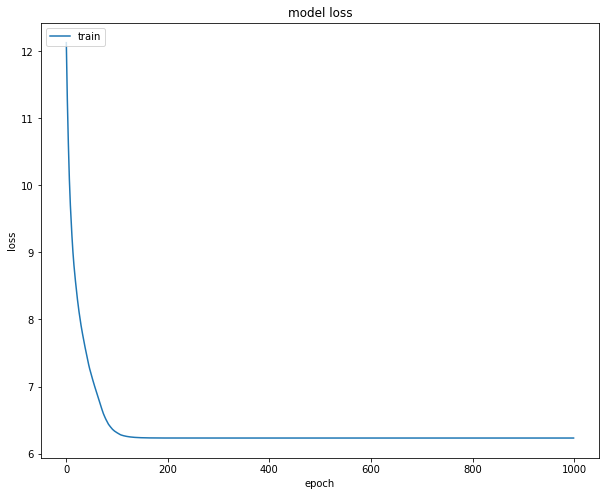

<IPython.core.display.Javascript object>

In [117]:
plt.figure(figsize=(10, 8))
plt.plot(wm_model_hist.history["loss"])
# plt.plot(wm_model_hist.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train"], loc="upper left")
plt.show()

In [129]:
labels_pred_nn = wm_model.predict(word_meaning_features)[:, 0]
mean_squared_error(word_meaning_labels, labels_pred_nn)

6.231587648043673

<IPython.core.display.Javascript object>

In [130]:
def plot_corr(true_labels: np.ndarray, pred_labels: np.ndarray) -> None:
    """
    TODO: Docs
    """
    corr, _ = pearsonr(pred_labels, true_labels)
    plt.figure(figsize=(10, 10))
    plt.scatter(labels_pred_nn, word_meaning_labels)
    plt.title(f"true/pred correlation: {corr:.3f}")
    plt.show()

<IPython.core.display.Javascript object>

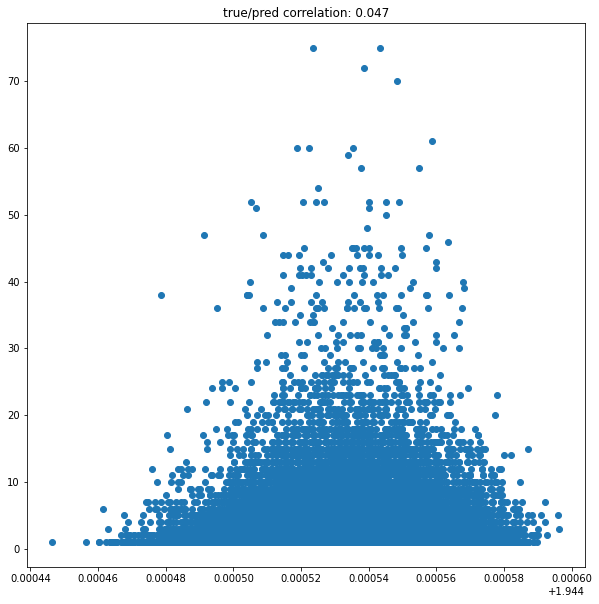

<IPython.core.display.Javascript object>

In [131]:
plot_corr(word_meaning_labels, labels_pred_nn)

In [121]:
# Lasso regression
lasso_clf = Lasso(alpha=0.7, random_state=rng_seed)
lasso_clf.fit(X=word_meaning_features, y=word_meaning_labels)

labels_pred = lasso_clf.predict(word_meaning_features)
mean_squared_error(word_meaning_labels, labels_pred)

6.23159132276085

<IPython.core.display.Javascript object>

In [122]:
labels_pred

array([1.94496302, 1.94496302, 1.94496302, ..., 1.94496302, 1.94496302,
       1.94496302])

<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


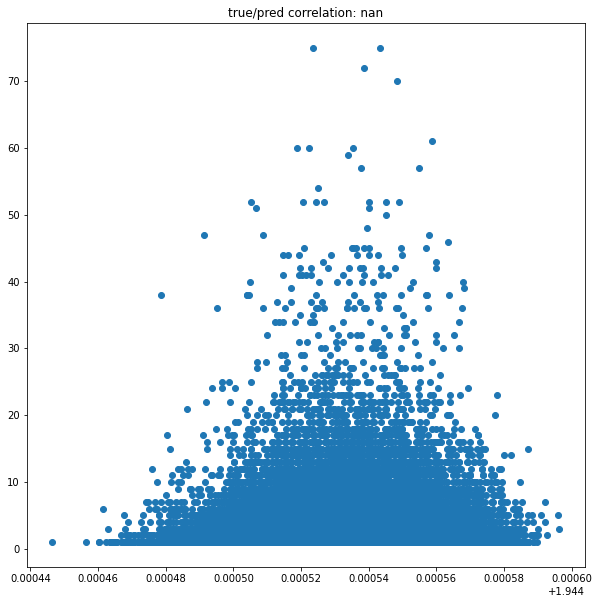

<IPython.core.display.Javascript object>

In [123]:
plot_corr(word_meaning_labels, labels_pred)